# Exercise 2: Data Augmentation
Taking a picture of an object from a different angle does not change the type of the object. 
Machine learning models overfitting to learn to only recognize an object from a single angle or, worse, under certain lighting conditions or with certain backgrounds is a real problem.
Luckily, it is possible to lower this risk without taking new data but, instead, altering existing images in a dataset.
This process is called "data agumentation" and it will be the focus of this excercise.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras import Sequential
from keras import layers
import keras

Using TensorFlow backend.


## Load in Data
We are going to use the [CIFAR 10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset as an example.
This dataset contains pictures of many differnet kinds of objects

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

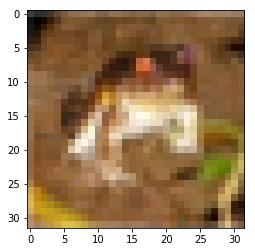

In [3]:
fig, ax = plt.subplots()

ax.imshow(x_train[0])

I'm not sure what I'm looking at here. Let's hope our CNN does

As before, we need to convert the labels into a binary representation and images into a floating point number

In [4]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Illustrate Data Augmentation
A few things we can do to this picture to emulate taking a picture with a different camera, view, etc are:
- Rotate the image
- Darken it
- Magnify it
Keras has a tool, [ImageDataGenerator](https://keras.io/preprocessing/image/), that helps with this process.

In [6]:
gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
                         rotation_range=45, shear_range=20, validation_split=0.1)

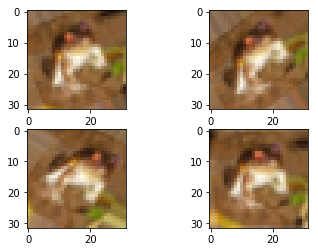

In [7]:
fig, axs = plt.subplots(2, 2)

for ax in axs.flatten():
    ax.imshow(gen.random_transform(x_train[0]))

Hopefully, this is the right kind of noise to help the model generalize better

## Fitting without augmentation
Just to serve as a baseline. We will borrow the architecture from the [Keras example for CIFAR](https://keras.io/examples/cifar10_cnn/).

In [8]:
def make_model():
    return Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                      input_shape=x_train.shape[1:]),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                      input_shape=x_train.shape[1:]),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      input_shape=x_train.shape[1:]),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      input_shape=x_train.shape[1:]),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

In [9]:
model = make_model()

In [10]:
model.compile('rmsprop', 'categorical_crossentropy', metrics=['acc'])

In [11]:
model.fit(x_train, y_train, batch_size=64, epochs=32)

Epoch 1/32
50000/50000 [==============================] - 24s 477us/step - loss: 1.5748 - acc: 0.4311
Epoch 2/32
14784/50000 [=======>......................] - ETA: 15s - loss: 1.1780 - acc: 0.5841

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(x_test, y_test)
print('Accuracy: {}'.format(scores[1]))

## Fitting a CNN with Augmentation
You now have a tool that will generate a new series of images given a current training set. 
Rather than generating all of the images in advance, Keras lets you generate them on-the-fly with the `fit_generator` function.



Making a generator with [reasonable settings](https://keras.io/examples/cifar10_cnn/)

In [12]:
gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.)

In [13]:
model = make_model()
model.compile('rmsprop', 'categorical_crossentropy', metrics=['acc'])

In [18]:
gen.fit(x_train)  # Need to fit the model for some of the random moves

In [17]:
model.fit_generator(gen.flow(x_train, y_train, batch_size=64),
                    steps_per_epoch=x_train.shape[0] // 64,
                    epochs=32)

Epoch 1/32
2399/3125 [======================>.......] - ETA: 21s - loss: 1.3874 - acc: 0.5039

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(x_test, y_test)
print('Accuracy: {}'.format(scores[1]))

Depending ont he random initialization, your accuracy should have gone up slightly!

## Still curious?
Try increasing the magnitude of the random changes. Can you reach a point where they cause more harm than good?